In [3]:
#start all integration scripts like this

import sys
sys.path.append('/home/pwahle/Organoid-Image-Analysis/scripts/modules')
#alternative to sys.append('...'):
#set PYTHONPATH; in ~/.bashrc add below last line: export PYTHONPATH=/home/<your username>/Organoid-Image-Analysis/scripts/modules
#this option doesn't work for me.

import yaml 
import Paths #all kinds of paths, image paths are functions with default variables plate = "plate6", cycle = 'cycle1'; aligned_images_path has no variable 'cylce'. 


#load parameters
with open("../../params.yml", 'r') as ymlfile: 
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
globals().update(cfg) # optional, 'activates' all parameters

In [2]:
from skimage import io
from matplotlib import pyplot as plt
from skimage import filters
import os
#import cv2 as cv
import numpy as np
import matplotlib
from skimage.filters import threshold_otsu
from skimage.filters import threshold_multiotsu
import copy
from skimage.feature import blob_log
import toolz
import imp
import imageio
import Example



folder = Paths.aligned_images_path() + "/MAX_Time00000_Point0000_Point00{ii}_ChannelSCF_SD"



mem = io.imread(folder + "/cycles/cycle1_aligned.tif")
membrane = mem[...,1]
membrane_sub = mem[2000:3000,2000:3000,0:3].astype('int8')
dapi = io.imread(folder + "/cycles/cycle1_aligned.tif")[...,2]
#dapi = dapi[2000:3000, 2000:3000]
safe = copy.deepcopy(dapi)
#dapi = cv.cvtColor(dapi.astype('uint8'), cv.COLOR_GRAY2BGR)

segmented_normal = io.imread(folder + "/dapi_mask.tif") # to generate this use Example.initial_segment(dapi = dapi, membrane = membrane)
segmented_log = io.imread(folder + "/dapi_mask_log_membrane.tif") #to generate this use Example.initial_segment(dapi = dapi, membrane = np.log(membrane))

subtracted = Example.subtract_membrane(dapi, membrane)



#io.imsave(folder + '/subtracted.tif', subtracted.astype('uint16'))

ModuleNotFoundError: No module named 'cv2'

In [4]:
'''imp.reload(Example)

testdapi = dapi[2000:3000,2000:3000]
testmembrane = membrane[2000:3000,2000:3000]
testimage = Example.initial_segment(dapi = testdapi, membrane = testmembrane)'''

'imp.reload(Example)\n\ntestdapi = dapi[2000:3000,2000:3000]\ntestmembrane = membrane[2000:3000,2000:3000]\ntestimage = Example.initial_segment(dapi = testdapi, membrane = testmembrane)'

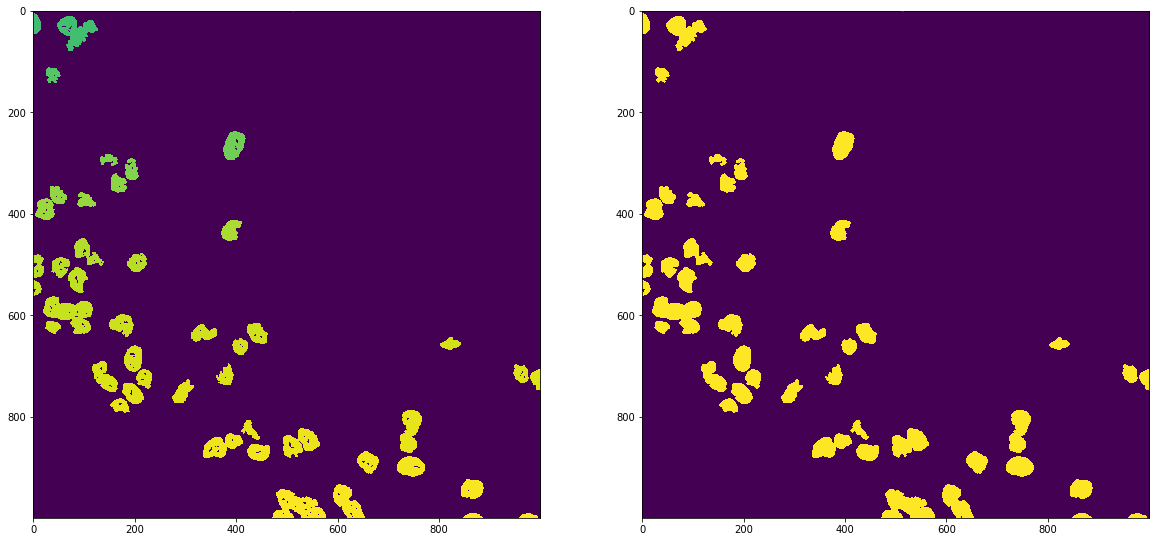

In [5]:
testimage = segmented_log[2000:3000,2000:3000]


bintestimage = np.where(testimage>0.5, 1000, 0)
bintestimage = np.uint8(bintestimage)

contour,hier = cv.findContours(bintestimage,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)

for cnt in contour:
    cv.drawContours(bintestimage,[cnt],0,255,-1)
    
#kernel = np.ones((3,3),np.uint8)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
opening = cv.morphologyEx(bintestimage,cv.MORPH_OPEN, kernel, iterations = 2)

fig, ax = plt.subplots(1,2, figsize = (20,20))
ax[0].imshow(testimage)
ax[1].imshow(opening)
plt.show()

In [6]:
sure_bg = cv.dilate(opening, kernel, iterations = 10)

dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 3)


for i in (np.arange(8)+1)/10:
    
    ret2, sure_fg = cv.threshold(dist_transform, i*dist_transform.max(), 255,0)

    sure_fg = np.uint8(sure_fg)

    unknown = cv.subtract(sure_bg, sure_fg)

    ret3, markers = cv.connectedComponents(sure_fg)

    markers = markers + 10

    markers[unknown == 255] = 0


    markers = markers.astype('int32')

    markers = cv.watershed(dapi, markers)
    
    safes = copy.deepcopy(safe)
    safes = safes.astype('int32')

    safes[markers == -1] = 4000
    
    markers = (markers + 1) **2

    fig, ax = plt.subplots(1,2, figsize = (20,20))
    ax[0].imshow(safes)
    ax[1].imshow(markers)
    plt.figure(i+1)

plt.show()

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'watershed'
